In [1]:
import sys
import os
sys.path.append("/home/luke/VIU/09MIAR/src")

from vae.datasets.audio_dataset import AudioDataset
from vae.datasets.mp3_validator import MP3ValidatorDataset
from vae.datasources.fma_datasource import FMADatasource
import torch
from torch.utils.data import DataLoader

from dotenv import load_dotenv
load_dotenv('./VIU/09MIAR/src/vae/.env')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

datasets_path = '/home/luke/VIU/09MIAR/datasets'
valid_files_csv_path = '/home/luke/valid_files.csv'

def get_dataloader(datasets_path, valid_files_csv_path, num_mels):
    fma_dataset = FMADatasource(datasets_path)

    file_paths = fma_dataset.get_file_paths()
    labels = fma_dataset.get_labels()
    mp3Validator = MP3ValidatorDataset(file_paths,labels,valid_files_csv_path,num_mels,10,25,int(os.environ.get('SAMPLE_RATE')))
     
    num_tracks_per_genre, dict_dataset = fma_dataset.balanced(mp3Validator.getValidFiles() ,int(os.environ.get('LIMIT_FILES'))) # TODO: REMOVE -> limited to 500

    file_paths = list(dict_dataset.keys())
    labels = [dict_dataset[fp]['label'] for fp in file_paths]

    dataset = AudioDataset(file_paths, labels)
    print('dataset done')
    
    # dataloader = DataLoader(dataset, int(os.environ.get('TRAIN_BATCH_SIZE')), shuffle=False, drop_last=True, pin_memory=False)
    dataloader = DataLoader(dataset, int(os.environ.get('TRAIN_BATCH_SIZE')), shuffle=True, num_workers=30)
    print('dataloader done')

    return dataloader, dataset

dataloader, dataset = get_dataloader(datasets_path, valid_files_csv_path, int(os.environ.get('NUM_MELS')))


Creating valid_files
done valid_files
dataset done
dataloader done


In [ ]:
from torch.utils.data import random_split, DataLoader
import pytorch_lightning as pl

class VAEDataModule(pl.LightningDataModule):
    def __init__(self,
                 dataset_cls=None,
                 dataset_kwargs=None,
                 train_dataset=None,
                 val_dataset=None,
                 val_split=0.2,
                 batch_size=1,
                 num_workers=0):
        super().__init__()
        self.dataset_cls = dataset_cls
        self.dataset_kwargs = dataset_kwargs or {}
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.val_split = val_split
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        if self.train_dataset is not None and self.val_dataset is not None:
            return

        if self.train_dataset is not None and self.val_dataset is None:
            total_len = len(self.train_dataset)
            train_len = int((1 - self.val_split) * total_len)
            val_len = total_len - train_len
            self.train_dataset, self.val_dataset = random_split(self.train_dataset, [train_len, val_len])
            return

        if self.dataset_cls is None:
            raise ValueError("Debe proporcionar 'dataset_cls' si no pasa ningún dataset ya instanciado.")

        full_dataset = self.dataset_cls(**self.dataset_kwargs)
        train_size = int((1 - self.val_split) * len(full_dataset))
        val_size = len(full_dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size])



    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)


In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from dotenv import load_dotenv


load_dotenv('./VIU/09MIAR/src/vae/.env')
SAMPLE_RATE = int(os.environ["SAMPLE_RATE"])
N_FFT = int(os.environ["N_FFT"])
HOP_LENGTH = int(os.environ["HOP_LENGTH"])
NUM_MELS = int(os.environ["NUM_MELS"])
SEGMENT_DURATION = int(os.environ["SEGMENT_DURATION"])
LATENT_DIM = int(os.environ["LATENT_DIM"])
NUM_GENRES = int(os.environ["NUM_GENRES"])


SPEC_TIME_STEPS = int((SAMPLE_RATE * SEGMENT_DURATION) / HOP_LENGTH)
print(f"SPEC_TIME_STEPS {SPEC_TIME_STEPS}")


def next_power_of_two(n):
    return 2 ** math.ceil(math.log2(n))

GENRE_EMBEDDING_DIM = next_power_of_two(NUM_GENRES)
print(f"GENRE_EMBEDDING_DIM {GENRE_EMBEDDING_DIM}")

class VAE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.genre_embedding = nn.Embedding(NUM_GENRES, GENRE_EMBEDDING_DIM)

        self.conv1 = nn.Conv2d(1 + GENRE_EMBEDDING_DIM, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2)

        with torch.no_grad():
            dummy_spec = torch.zeros(1, 1, NUM_MELS, SPEC_TIME_STEPS)
            dummy_genre = torch.zeros(1, dtype=torch.long)
            dummy_emb = self.genre_embedding(dummy_genre).view(1, GENRE_EMBEDDING_DIM, 1, 1).expand(-1, -1, NUM_MELS, SPEC_TIME_STEPS)
            dummy_input = torch.cat([dummy_spec, dummy_emb], dim=1)

            dummy = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            dummy = self.pool(F.relu(self.bn2(self.conv2(dummy))))
            dummy = self.pool(F.relu(self.bn3(self.conv3(dummy))))

            self.flattened_shape = dummy.shape[1:]
            self.feature_dim = dummy.numel()

        self.fc_mu = nn.Linear(self.feature_dim, LATENT_DIM)
        self.fc_logvar = nn.Linear(self.feature_dim, LATENT_DIM)

    def forward(self, x, genre):
        x = x[..., :SPEC_TIME_STEPS]
        genre_emb = self.genre_embedding(genre).view(genre.size(0), GENRE_EMBEDDING_DIM, 1, 1)
        genre_emb = genre_emb.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, genre_emb], dim=1)

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        logvar = torch.clamp(logvar, min=-10.0, max=10.0)
        return mu, logvar




class VAE_Decoder(nn.Module):
    def __init__(self, feature_dim, flattened_shape):
        super().__init__()
        self.feature_dim = feature_dim
        self.flattened_shape = flattened_shape

        self.genre_embedding = nn.Embedding(NUM_GENRES, GENRE_EMBEDDING_DIM)
        self.fc = nn.Linear(LATENT_DIM + GENRE_EMBEDDING_DIM, feature_dim)

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        self.output_pad = nn.ConstantPad2d((0, 5), 0)

    def forward(self, z, genre):
        genre_emb = self.genre_embedding(genre)
        z = torch.cat([z, genre_emb], dim=1)

        x = self.fc(z)
        x = x.view(z.size(0), *self.flattened_shape)


        x = x.permute(0, 2, 1, 3)
        B, H, C, W = x.shape
        x = x.reshape(B * H, C, W).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1).reshape(B, H, C, W)
        x = x.permute(0, 2, 1, 3)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        x = self.deconv3(x)
        x = self.output_pad(x)
        
        if not self.training:
            import matplotlib.pyplot as plt

            flat = x.detach().cpu().flatten()
            x_min = flat.min().item()
            x_max = flat.max().item()
            x_mean = flat.mean().item()
            x_std = flat.std().item()
            sat_low = (flat <= -0.95).float().mean().item()
            sat_high = (flat >= 0.95).float().mean().item()

            print(f"[DEBUG] Decoder output stats -> min: {x_min:.4f}, max: {x_max:.4f}, mean: {x_mean:.4f}, std: {x_std:.4f}")
            print(f"[DEBUG] Saturación -> <= -0.95: {sat_low:.2%}, >= 0.95: {sat_high:.2%}")

            plt.figure(figsize=(6, 4))
            plt.hist(flat.numpy(), bins=50, color='purple', alpha=0.75)
            plt.title("Histograma de valores del decoder")
            plt.xlabel("Valor")
            plt.ylabel("Frecuencia")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        return x



class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAE_Encoder()
        self.decoder = VAE_Decoder(self.encoder.feature_dim, self.encoder.flattened_shape)
        self.apply(self.init_weights)

    def init_weights(self,m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.uniform_(m.weight, -0.1, 0.1)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, genre):
        # print(f"[ENCODER IN] x mean: {x.mean().item():.4f}, std: {x.std().item():.4f}")
        mu, logvar = self.encoder(x, genre)
        # print(f"[LATENT] mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
        # print(f"[LATENT] logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")

        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z, genre)
        if not torch.isfinite(x_hat).all():
            print("[ERROR] x_hat contiene NaNs")

        # print(f"[DECODER OUT] x_recon mean: {x_hat.mean().item():.4f}, std: {x_hat.std().item():.4f}")


        if not torch.isfinite(x).all():
            print("[ERROR] Input contiene NaNs o infinitos")
        if not torch.isfinite(mu).all():
            print("[ERROR] mu contiene NaNs")
        if not torch.isfinite(logvar).all():
            print("[ERROR] logvar contiene NaNs")

        return x_hat, mu, logvar



BETA_MAX = float(os.environ["BETA_MAX"])
BETA_WARMUP_EPOCHS = int(os.environ["BETA_WARMUP_EPOCHS"])


import json

class LitVAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = VAE()
        self.register_buffer("x_sum", torch.tensor(0.0))
        self.register_buffer("x_squared_sum", torch.tensor(0.0))
        self.register_buffer("x_count", torch.tensor(0))
        self.std_x = 0
        self.mean_x = 0
        self.best_val_loss = float("inf")

        # Logs
        self.train_step_metrics = []
        self.val_step_metrics = []
        self.train_epoch_metrics = []
        self.val_epoch_metrics = []

        os.makedirs("logs/csv", exist_ok=True)
        os.makedirs("logs/img", exist_ok=True)
        os.makedirs("checkpoints", exist_ok=True)

    def forward(self, x, genre):
        x = x[..., :SPEC_TIME_STEPS]
        x_hat, mu, logvar = self.model(x, genre)
        x_hat = x_hat[..., :SPEC_TIME_STEPS]
        if x_hat.shape[-1] != x.shape[-1]:
            min_width = min(x_hat.shape[-1], x.shape[-1])
            x = x[..., :min_width]
            x_hat = x_hat[..., :min_width]
        return x_hat, x, mu, logvar

    def compute_loss(self, x_hat, x, mu, logvar):
        warmup = max(BETA_WARMUP_EPOCHS, 1)
        step = self.current_epoch / warmup
        beta = float(BETA_MAX / (1 + math.exp(-10 * (step - 0.5))))
        beta = min(beta, BETA_MAX)

        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + beta * kl_div
        return loss, recon_loss, kl_div, beta

    def training_step(self, batch, batch_idx):
        x, genre = batch
        x_hat, x, mu, logvar = self(x, genre)

        self.x_sum += x.sum()
        self.x_squared_sum += (x ** 2).sum()
        self.x_count += x.numel()

        loss, recon_loss, kl_div, beta = self.compute_loss(x_hat, x, mu, logvar)

        self.log("loss", loss, prog_bar=True)
        self.log("recon_loss", recon_loss, prog_bar=True)
        self.log("kl_div", kl_div, prog_bar=True)
        self.log("beta", beta, prog_bar=True)

        self.train_step_metrics.append({
            "epoch": self.current_epoch,
            "batch": batch_idx,
            "loss": loss.item(),
            "recon_loss": recon_loss.item(),
            "kl_div": kl_div.item(),
            "beta": beta
        })
        return loss

    def validation_step(self, batch, batch_idx):
        x, genre = batch
        x_hat, x, mu, logvar = self(x, genre)
        loss, recon_loss, kl_div, beta = self.compute_loss(x_hat, x, mu, logvar)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_recon_loss", recon_loss, prog_bar=True)
        self.log("val_kl_div", kl_div, prog_bar=True)

        self.val_step_metrics.append({
            "epoch": self.current_epoch,
            "batch": batch_idx,
            "val_loss": loss.item(),
            "val_recon_loss": recon_loss.item(),
            "val_kl_div": kl_div.item(),
            "beta": beta
        })
        return loss

    def on_train_epoch_end(self):
        if self.x_count > 0:
            mean_x = self.x_sum / self.x_count
            std_x = torch.sqrt(self.x_squared_sum / self.x_count - mean_x ** 2)
            self.mean_x = mean_x.item()
            self.std_x = std_x.item()
            self.log("x_mean_epoch", mean_x, prog_bar=True)
            self.log("x_std_epoch", std_x, prog_bar=True)
            print(f"[INFO] Época {self.current_epoch} completada — mean_x={self.mean_x:.4f}, std_x={self.std_x:.4f}")
        self.x_sum.zero_()
        self.x_squared_sum.zero_()
        self.x_count.zero_()

        import pandas as pd
        import matplotlib.pyplot as plt
        import torch

        if self.train_step_metrics:
            df_train = pd.DataFrame(self.train_step_metrics)
            df_train.to_csv("logs/csv/metrics_train_step.csv", mode='a', header=not os.path.exists("logs/csv/metrics_train_step.csv"), index=False)
            self.train_step_metrics.clear()

        if self.val_step_metrics:
            df_val = pd.DataFrame(self.val_step_metrics)
            df_val.to_csv("logs/csv/metrics_val_step.csv", mode='a', header=not os.path.exists("logs/csv/metrics_val_step.csv"), index=False)
            self.val_step_metrics.clear()

        epoch_metrics = {
            "epoch": self.current_epoch,
            "x_mean": self.mean_x,
            "x_std": self.std_x
        }
        self.train_epoch_metrics.append(epoch_metrics)
        df_epoch = pd.DataFrame(self.train_epoch_metrics)
        df_epoch.to_csv("logs/csv/metrics_train_epoch.csv", index=False)

        if self.val_epoch_metrics:
            df_val_epoch = pd.DataFrame(self.val_epoch_metrics)
            df_val_epoch.to_csv("logs/csv/metrics_val_epoch.csv", index=False)

        if len(df_epoch) > 1:
            plt.figure()
            plt.plot(df_epoch["epoch"], df_epoch["x_mean"], label="x_mean")
            plt.plot(df_epoch["epoch"], df_epoch["x_std"], label="x_std")
            plt.xlabel("Epoch")
            plt.ylabel("Valor")
            plt.legend()
            plt.title("Media y desviación estándar de x")
            plt.savefig(f"logs/img/stats_epoch_{self.current_epoch}.jpg")
            plt.close()

        torch.save(self.state_dict(), f'''checkpoints/vae_last_{self.current_epoch}.pt''')

        if self.val_epoch_metrics:
            current_val_loss = self.val_epoch_metrics[-1]["val_loss"]
            if current_val_loss < self.best_val_loss:
                self.best_val_loss = current_val_loss
                torch.save(self.state_dict(), f"checkpoints/vae_best.pt")
                print(f"[INFO] Nuevo mejor modelo guardado (val_loss={current_val_loss:.4f})")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            }
        }

SPEC_TIME_STEPS 501
GENRE_EMBEDDING_DIM 8


In [ ]:

# model = LitVAE()

# 
# trainer = pl.Trainer(max_epochs=int(os.environ.get('TRAIN_EPOCHS')))

# 
# trainer.fit(model, dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-30 12:01:24.718474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 12:01:24.736614: I tensorflow/core/platform/cpu_feature_guard.cc:210] T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Decoder output stats -> min: -2.5498, max: 2.0577, mean: -0.1738, std: 0.5428
[DEBUG] Saturación -> <= -0.95: 7.86%, >= 0.95: 1.84%


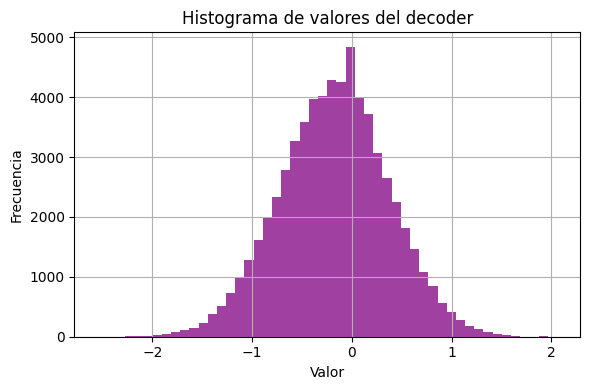

[DEBUG] Decoder output stats -> min: -2.4712, max: 2.5233, mean: -0.1719, std: 0.5497
[DEBUG] Saturación -> <= -0.95: 8.06%, >= 0.95: 1.98%


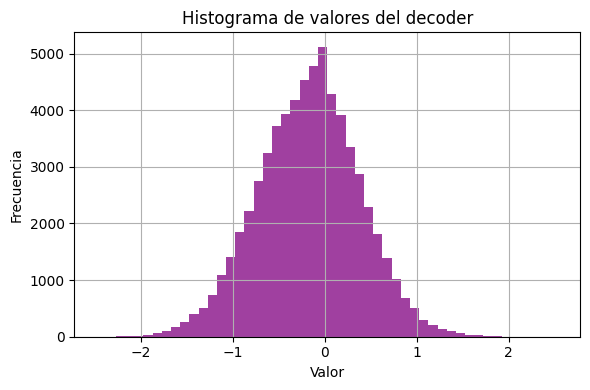

Training: |          | 0/? [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:


model = LitVAE()

from torch.utils.data import random_split


data_module = VAEDataModule(
    train_dataset=dataset,
    val_split=0.2,
    batch_size=1,
    num_workers=32
)

from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=int(os.environ.get('TRAIN_EPOCHS')),
    accelerator="auto",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True
)
trainer.fit(model, datamodule=data_module)


In [ ]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt

def generate_audio_from_noise(model: LitVAE, genre_id: int, output_path: str = "generated.wav"):
    DB_MIN = -80.0
    DB_MAX = 0.0

    device = model.device
    model.eval()
    vae = model.model

    z = torch.randn(1, LATENT_DIM).to(device)
    genre = torch.tensor([genre_id], dtype=torch.long).to(device)

    with torch.no_grad():
        spec = vae.decoder(z, genre)

    spec = spec.squeeze().cpu()

    spec_min = spec.min().item()
    spec_max = spec.max().item()
    print(f"[DEBUG] spec antes de denormalizar: min={spec_min:.4f}, max={spec_max:.4f}")

    if abs(spec_max - spec_min) < 1e-3:
        print("[WARNING] El espectrograma generado tiene un rango demasiado pequeño")

    try:
        mean_x = model.mean_x.item() if hasattr(model.mean_x, 'item') else float(model.mean_x)
        std_x = model.std_x.item() if hasattr(model.std_x, 'item') else float(model.std_x)
        print(f"[INFO] Usando mean_x={mean_x}, std_x={std_x} para denormalización temporal")
    except Exception as e:
        print(f"[ERROR] Acceso a mean_x o std_x: {e}")
        mean_x, std_x = 0.0, 1.0

    if std_x == 0:
        print("[WARNING] std_x es 0, se omite denormalización")
    else:
        spec = spec * std_x + mean_x

    spec_db = spec * (DB_MAX - DB_MIN) + DB_MIN

    plt.figure(figsize=(10, 4))
    plt.imshow(spec_db.numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Espectrograma generado (género {genre_id})")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    
    inverse_mel = torchaudio.transforms.InverseMelScale(
        n_stft=N_FFT // 2 + 1,
        n_mels=NUM_MELS,
        sample_rate=SAMPLE_RATE,
    )
    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        power=2.0
    )

    spec_amp = torch.pow(10.0, spec_db / 20.0)
    spec_amp = spec_amp.unsqueeze(0)
    linear_spec = inverse_mel(spec_amp)
    waveform = griffin_lim(linear_spec)

    torchaudio.save(output_path, waveform, SAMPLE_RATE)
    print(f"Audio generado guardado en: {output_path}")

    return waveform


In [ ]:
generate_audio_from_noise(model, genre_id=0, output_path="sample_genre0.wav")
generate_audio_from_noise(model, genre_id=1, output_path="sample_genre1.wav")
generate_audio_from_noise(model, genre_id=2, output_path="sample_genre2.wav")
generate_audio_from_noise(model, genre_id=3, output_path="sample_genre3.wav")
generate_audio_from_noise(model, genre_id=4, output_path="sample_genre4.wav")
generate_audio_from_noise(model, genre_id=7, output_path="sample_genre7.wav")

In [ ]:
batch = next(iter(dataloader))


x, y = batch

print("Shape del batch completo (x):", x.shape)
print("Shape del target (y):", y.shape if y is not None else "None")


print("\nEjemplo individual:")
ejemplo = x[0]
print("Shape del ejemplo:", ejemplo.shape)


import matplotlib.pyplot as plt

if ejemplo.ndim == 3:

    plt.imshow(ejemplo.squeeze().cpu(), aspect='auto', origin='lower')
    plt.title("Espectrograma del primer segmento")
    plt.colorbar()
    plt.show()
elif ejemplo.ndim == 4:

    print("Número de segmentos:", ejemplo.shape[0])
    fig, axs = plt.subplots(1, ejemplo.shape[0], figsize=(15, 3))
    for i in range(ejemplo.shape[0]):
        axs[i].imshow(ejemplo[i].squeeze().cpu(), aspect='auto', origin='lower')
        axs[i].set_title(f"Segmento {i+1}")
    plt.show()
else:
    print("Formato no esperado.")